# Similarity of fund products

Inspect and determine similarity of fund products on different levels

Compare portfolio weights, price correlations and other measurements, to determine similarity of ETFs and reference portfolios

## Develope different measures of dissimlarity and aggregate into single measure with adjustable weights

* Number of shared top 10 holdings
* % PF Equal (min(isin_w_i, isin_w_j))
* DO NOT: Correlation of prices over different periods of time -> Make this a separate topic!
* ...

Find different visuatlizations for each measure of dissimilarity. Make it intuititve to see the differences!

* Graph Networks
* Heatmap (correlation)
* 


Show similarity of funds to benchmark fund: iShares ACWI & iShares MSCI World Core

Find N Clusters -> Show how unevenly sized they are. Largest cluster will be (World, USA) & Europe. For each cluster, show top 10 holdings !!!
-> Maybe distributions of top 25 holdings -> violinplot per holding over all funds?

In [2]:
# General
import pandas as pd
import numpy as np
from itertools import product

# Custom modules
import Tools

# Hidden configurations
from mySecrets import AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, AWS_BUCKET, config_file

In [1]:
# Connect to AWS S3 storage
# s3 = Tools.S3()
# s3.connect(AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY)

In [4]:
# Read config table for (ISIN / Provider) mapping
config = pd.read_excel(config_file, sheet_name="ETF_Overview", header=1)
# config = config[['Security_ISIN', 'Fund_Company', 'Type']]
config.head()

,SecurityGroup_ID,SecurityGroup_Name,Security_ID,Security_ISIN,Security_Name,Security_Class,Fund_Company,Domicile,TER,Type,...,Unnamed: 30,URL,URL_Overview,URL_Overview_FileType,URL_Positions,URL_Positions_FileType,URL_Dividend,URL_Dividend_FileType,URL_NAV,URL_NAV_Type
0,NaN,NaN,1000001,LU0836512706,iShares Europe Equity Index A2 EUR,ETF,iShares,Luxemburg,-,Aktien,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1000002,LU0836513852,iShares Global Government Bond Index Fund (LU)...,ETF,iShares,Luxemburg,-,Anleihen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,1000003,LU0836512615,iShares World Equity Index Fund (LU) Class A2 USD,ETF,iShares,Luxemburg,-,Aktien,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,1000004,LU0836513266,iShares Euro Government Bd Index A2 EUR,ETF,iShares,Luxemburg,-,Anleihen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,1000005,LU0836512888,iShares Japan Equity Index Fund (LU) Class A2 USD,ETF,iShares,Luxemburg,-,Aktien,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Get data from S3

Download all available fund data for specific reference date

* Holdings
* Prices (tbd)

In [5]:
# Download all position files
file_list = s3.listFiles(AWS_BUCKET, "data/position_trans/2022_03_04")

# Filter to files ending in .tsv
file_list = [i for i in file_list if '.tsv' in i]

positions = pd.DataFrame(columns = ['ISIN_FUND', 'ISIN', 'NAME', 'WEIGHT', 'TICKER', 'SECTOR', 'EXCHANGE', 'COUNTRY'])

for key in file_list:

    data = s3.readFile(AWS_BUCKET, key, sep = "\t")  

    # Subset columns
    cols = ['ISIN_FUND', 'ISIN', 'NAME', 'WEIGHT', 'TICKER', 'SECTOR', 'EXCHANGE', 'COUNTRY']
    data = data[[i for i in cols if i in data.columns]]

    # Append 
    positions = positions.append(data)

# Store in data format readable by both Python and R
positions = positions.reset_index().drop(['index'], axis = 1)

positions.head()

,ISIN_FUND,ISIN,NAME,WEIGHT,TICKER,SECTOR,EXCHANGE,COUNTRY
0,DE0002635265,DE000HV2AS10,UNICREDIT BANK AG RegS,1.01,HVB,Gedeckt,-,Deutschland
1,DE0002635265,DE000A1KRJV6,ING DIBA AG RegS,0.97,INGDIB,Gedeckt,-,Deutschland
2,DE0002635265,DE000CZ45VS1,COMMERZBANK AG MTN RegS,0.88,CMZB,Gedeckt,-,Deutschland
3,DE0002635265,XS2106576494,LANDESBANK HESSEN THUERINGEN GIROZ MTN RegS,0.84,HESLAN,Gedeckt,-,Deutschland
4,DE0002635265,XS1767931477,LANDESBANK HESSEN THUERINGEN GIROZ RegS,0.83,HESLAN,Gedeckt,-,Deutschland


## Calculate distance measures

First, calculate dissimilarity for each measure. Then, aggregate weighted to total measure of dissimilarity.

* Common Top 10 Holdings -> N_Common_Top10
* Squared difference of portfolio weights -> stupid
* Sum of common portfolio weights
* Correlation of prices
    * Over 1 year
    * During boom/crisis periods (2008, 2016, ...)
    


In [6]:
# Prepare dataframe to collect all information

# ISIN_FUND_I; ISIN_FUND_J, D_Positions, D_Price_1Y, ...
isin_fund_unique = positions.ISIN_FUND.unique()
df = list(product(isin_fund_unique, isin_fund_unique))
df = pd.DataFrame(df, columns = ['ISIN_FUND_I', 'ISIN_FUND_J'])

df.head()

,ISIN_FUND_I,ISIN_FUND_J
0,DE0002635265,DE0002635265
1,DE0002635265,DE0002635273
2,DE0002635265,DE0002635281
3,DE0002635265,DE0002635299
4,DE0002635265,DE0002635307


### Preparations

In [7]:
# Exclude certain funds
# Which have special portfolio conditions, like weights of -99%
isin_to_exclude = ['IE00BQXKVQ19']

positions = positions[~positions.ISIN_FUND.isin(isin_to_exclude)]



In [8]:
# Rescale Weight to [0,1] => Some are [0,100] and other [0,1]

positions = (
    positions
    .join(
        positions.groupby('ISIN_FUND').agg({'WEIGHT':'sum'}).rename(columns = {'WEIGHT': 'W_Total'}),
        on = 'ISIN_FUND',
        how = 'left'
    )
    .assign(WEIGHT = lambda x: x.WEIGHT / x.W_Total)
    .drop('W_Total', axis = 1)
)



### Squared Difference of Portfolio Weights

In [9]:
# Calculate the squared difference of portfolio weights for each product with all others
d_positions = positions[['ISIN_FUND', 'ISIN', 'WEIGHT']]

# Replace missing ISIN with "Other"
d_positions = (
    d_positions
    .fillna(value = {'ISIN': 'Other'})
    # Aggreagte over possible duplicates
    .groupby(['ISIN_FUND', 'ISIN'])
    .agg({'WEIGHT':'sum'})
    .reset_index()
    .pivot(index = 'ISIN', columns = 'ISIN_FUND', values = 'WEIGHT')
    .fillna(0)
)

In [10]:
# Calculate squared difference
m = d_positions.to_numpy()
m = np.matrix(m)

temp = []
# i = 0
for i in range(m.shape[1]):

    # Extract current column
    v_i = m[:,i]

    # Duplicate into matrix
    m_i = np.tile(v_i, m.shape[1])

    # Calculate differences
    m_d = (m - m_i)

    # Square all elements
    m_d_sq = np.square(m_d)

    # Sum column wise
    m_d_sq_sum = np.sum(m_d_sq, axis = 0)

    # Append
    temp.append([])
    temp[i] = m_d_sq_sum.tolist()[0]


In [11]:
# Transform data and add to collection
df_d_positions = pd.DataFrame(temp, columns = d_positions.columns)
df_d_positions['ISIN_FUND_I'] = d_positions.columns

# Reshape longer
df_d_positions = pd.melt(df_d_positions, id_vars = ['ISIN_FUND_I'], value_name = 'D_Positions', var_name = 'ISIN_FUND_J')

# Add to df with measures
df = df.join(df_d_positions.set_index(['ISIN_FUND_I', 'ISIN_FUND_J']), on = ['ISIN_FUND_I', 'ISIN_FUND_J'])

### Common Top 10 Holdings

In [12]:
# Calculate the squared difference of portfolio weights for each product with all others
df_top_10 = positions[['ISIN_FUND', 'ISIN', 'WEIGHT']]

# Extract top 10 holdings per ISIN_FUND
df_top_10 = (
    df_top_10
    # TODO: drop nAs
    .dropna(subset = ['ISIN'])
    .reset_index(drop = True)
    # Aggregate over possible duplicates
    .groupby(['ISIN_FUND', 'ISIN'])
    .agg({'WEIGHT':'sum'})
    .reset_index()
    # Select top 10 holdings for each Fund
    .groupby(['ISIN_FUND'])
    .apply(lambda x: x.sort_values(['WEIGHT'], ascending=False).head(10))
    .reset_index(drop=True)
)

# Reshape to required format for matrix
df_top_10 = (
    df_top_10
    # Reshape
    .pivot(index = 'ISIN', columns = 'ISIN_FUND', values = 'WEIGHT')
    .fillna(0)
)

In [13]:
# Use matrixes instead
m = df_top_10.to_numpy()
m = np.matrix(m)

temp = []
# i = 0
for i in range(m.shape[1]):

    # Extract current column
    v_i = m[:,i]

    # Duplicate into matrix
    m_i = np.tile(v_i, m.shape[1])

    # Calculate differences
    m_d = np.multiply((m != 0), (m_i != 0))

    # Sum column wise
    m_d_sq_sum = np.sum(m_d, axis = 0)

    # Append
    temp.append([])
    temp[i] = m_d_sq_sum.tolist()[0]

In [14]:
# Transform data and add to collection
df_top_10_w = pd.DataFrame(temp, columns = df_top_10.columns)
df_top_10_w.index.rename('Index', inplace = True)
df_top_10_w['ISIN_FUND_I'] = df_top_10.columns

# Reshape longer
df_top_10_w = pd.melt(df_top_10_w, id_vars = ['ISIN_FUND_I'], value_name = 'N_Common_Top10', var_name = 'ISIN_FUND_J')

# Add to df with measures
df = df.join(df_top_10_w.set_index(['ISIN_FUND_I', 'ISIN_FUND_J']), on = ['ISIN_FUND_I', 'ISIN_FUND_J'], how = 'left')

### Sum of common portfolio weights

In [15]:
df_com_w = positions[['ISIN_FUND', 'ISIN', 'WEIGHT']]

# Replace missing ISIN with "Other"
df_com_w = (
    df_com_w
    .fillna(value = {'ISIN': 'Other'})
    # Aggreagte over possible duplicates
    .groupby(['ISIN_FUND', 'ISIN'])
    .agg({'WEIGHT':'sum'})
    .reset_index()
    .pivot(index = 'ISIN', columns = 'ISIN_FUND', values = 'WEIGHT')
    .fillna(0)
)

In [16]:
# Calculate sum of common weights
m = d_positions.to_numpy()
m = np.matrix(m)

temp = []
# i = 0
for i in range(m.shape[1]):

    # Extract current column
    v_i = m[:,i]

    # Duplicate into matrix
    m_i = np.tile(v_i, m.shape[1])

    # Calculate element-wise minimum
    m_min = np.minimum(m, m_i)

    # Sum column wise
    m_sum = np.sum(m_min, axis = 0)

    # Append
    temp.append([])
    temp[i] = m_sum.tolist()[0]

In [17]:
# Transform data and add to collection
df_d_positions = pd.DataFrame(temp, columns = d_positions.columns)
df_d_positions['ISIN_FUND_I'] = d_positions.columns

# Reshape longer
df_d_positions = pd.melt(df_d_positions, id_vars = ['ISIN_FUND_I'], value_name = 'Common_Weight', var_name = 'ISIN_FUND_J')

# Add to df with measures
df = df.join(df_d_positions.set_index(['ISIN_FUND_I', 'ISIN_FUND_J']), on = ['ISIN_FUND_I', 'ISIN_FUND_J'])

### Data Check

In [18]:
# Check for NA / infinite values in feature columns
df[df.D_Positions.isna()]
df[df.N_Common_Top10.isna()]
# df[df.Common_Weight.isna()]

# Replace NA values
# df.fillna()

,ISIN_FUND_I,ISIN_FUND_J,D_Positions,N_Common_Top10,Common_Weight
31,DE0002635265,DE000A0H0728,1.005332,NaN,0.0000
380,DE0002635265,IE00BQXKVQ19,NaN,NaN,NaN
618,DE0002635273,DE000A0H0728,1.073083,NaN,0.0034
967,DE0002635273,IE00BQXKVQ19,NaN,NaN,NaN
1205,DE0002635281,DE000A0H0728,1.016473,NaN,0.0099
...,...,...,...,...,...
343188,LU2197908721,IE00BQXKVQ19,NaN,NaN,NaN
343426,LU2263803533,DE000A0H0728,1.022366,NaN,0.0000
343775,LU2263803533,IE00BQXKVQ19,NaN,NaN,NaN
344013,LU2296661775,DE000A0H0728,1.021947,NaN,0.0000


# Graphics

## Fund Networks
Takumasa Sakakibara, Tohgoroh Matsui, Atsuko Mutoh, and Nobuhiro Inuzuka. Clustering mutual funds based on investment similarity. Procedia Computer Science, 60:881–890, 2015

Inspect top 10 holdings -> create visual network of how many assets are the same

There should be clusters for each region and completely isolated things! -> Bonds / Equities should be completely separate!!!

Use Plotly: https://plotly.com/python/network-graphs/

Or PyVis: https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259

networkx: https://networkx.org/documentation/stable/auto_examples/drawing/plot_random_geometric_graph.html


### Plan:
* Create graph layout with networkx
* Transform with few steps to plotly with annotations and hover-effects


Big problem: Every restart of the kernel results in new graphics! Cannot achieve reproducibility!!

In [19]:
# Define fill colors of edges for topic
# Define edgecolors for type (equity vs bond vs mix)

def map_colors(pos, config):

    df_colors = (
        pd.DataFrame(pos.keys(), columns = ['Security_ISIN'])
        .join(config[['Security_ISIN', 'Security_Name', 'Topic_Region', 'Topic_Type']].set_index('Security_ISIN'), on = 'Security_ISIN', how = 'left')
    )

    # df_colors.Topic_Region.unique()

    # Assign topics for color

    cond = {
        'World': ['#A9D08E', '#70AD47'],
        'Europe': ['#9BC2E6', '#5B9BD5'],
        'USA': ['#CC3399', '#990099'], # TODO from here
        'China': ['#CC0000','#A50021'],
        'India': ['#FF9933', '#CC6600'],
        'Japan': ['#FFCCCC', '#FF9999'],
        'Asia': ['#CCCC00', '#808000'],
        'EM': ['#33CCCC', '#009999'],

        'Latin America': ['#669900', '#336600'], #Brazil, Argentina, Venezuela
        'Oceania': ['#336699', '#003366'],
        'MiddleEast': ['#9933FF', '#6600CC'],
        'Other': ['#FFFFFF', '#FFFFFF']
    }

    condlist = []
    colors_fill = []
    colors_border = []
    for t, c in cond.items():
        condlist.append(df_colors.Topic_Region == t)
        colors_fill.append(c[0])
        colors_border.append(c[1])

    df_colors = df_colors.assign(
        Nodes = np.select(condlist, colors_fill),
        Edges = np.select(condlist, colors_border)
        )

    df_colors[df_colors.Nodes == "0"] = "#BFBFBF"
    df_colors[df_colors.Edges == "0"] = "#808080"

    return df_colors, cond

In [20]:
# Define labels of edges - select a few like iShares ACWI // MSCI CHINA // etc.
# Also label points that are at the plot margins!

def define_labels(config, label_sel):

    # label_sel = ['IE00B3F81G20', 'IE00B2QWDR12', 'IE00BF5LJ058', 'IE00B1FZS244', 'LU0494592974', 'LU0962078753', 
    # 'LU1109943388', 'LU0290357846', 'IE00B4WXJH41', 'IE00B0M63391', 'IE00BD3RYZ16', 'DE0005933923', 'LU0614173895',
    # 'LU1920015440', 'IE00B44CGS96', 'IE00BYYR0489']

    dict_labels = {}
    for i in label_sel:
        dict_labels[i] = config.loc[config.Security_ISIN == i]['Security_Name'].to_string(index = False)

    return dict_labels



In [32]:
# DONT: Work with LEI instead of ISIN? Should harmonize Bonds + Equity more and differences hsould be more about regions
# For most bonds, there is no LEI!!! There are many small Sparkassen-Bonds and others.

def plot_network(G, pos, df_colors, cond, dict_labels, labels = False):

    # Initial conditions
    plt.figure(figsize=(15, 15))

    # Add Legend
    f = plt.figure(1)
    ax = f.add_subplot(1,1,1)
    for lab, col in cond.items():
        ax.plot([0],[0],
                color=col[0],
                label=lab)

    # Draw network
    nx.draw_networkx(G, pos=pos, node_color=df_colors.Nodes, edgecolors=df_colors.Edges, linewidths=1,
    node_size=150, width=0.25, 
    alpha = 1,
    with_labels=labels, 
    labels = dict_labels,
    horizontalalignment='left', verticalalignment='center', font_color='black')

    # TODO: Label background boxes: light gray, round with gray borders

    # , alpha=0.5

    # Plot settings
    plt.axis('off')
    f.set_facecolor('w')

    plt.legend(loc='lower center', ncol=6, fontsize='x-large')

    f.tight_layout()
    # Display
    plt.show()

    return f

### Squared Differences

In [22]:
# # TODO: TAKES TOO LONG!!!
# import matplotlib.pyplot as plt
# import networkx as nx

# # Remove no connections
# df_plot = df[df.D_Positions > 0].copy()

# # Remove self-connections
# df_plot = df_plot[df_plot.ISIN_FUND_I != df_plot.ISIN_FUND_J]

# G = nx.from_pandas_edgelist(df_plot, "ISIN_FUND_I", 'ISIN_FUND_J', ['D_Positions'])
# # position is stored as node attribute data for random_geometric_graph
# pos = nx.kamada_kawai_layout(G, weight = 'D_Positions') 

# # Plot all ETFs with weights?!
# df_colors, cond = map_colors(pos, config)
# dict_labels = define_labels(config, label_sel = [])

# plot_network(G, pos, df_colors, cond, dict_labels)

### Common Top 10 Holdings

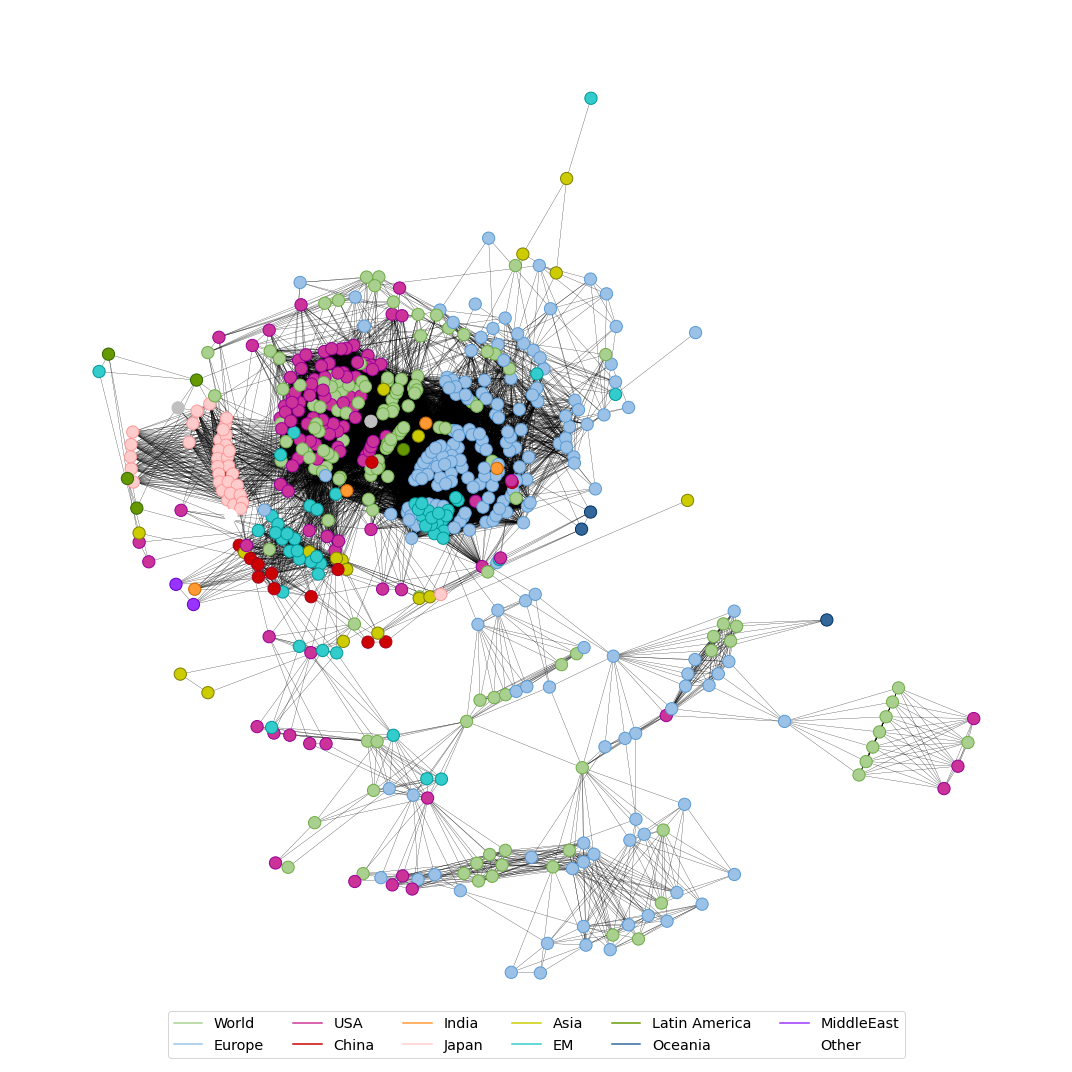

In [34]:
import matplotlib.pyplot as plt
import networkx as nx

# Remove no connections
df_plot = df[df.N_Common_Top10 != 0].copy()  

# Remove two swaps that ruin the graph
# Namely: iShares Diversified Commodity Swap AND MSCI GCC Select Swap
df_plot = df_plot[~df_plot.ISIN_FUND_I.isin(['DE000A0H0728', 'IE00BQXKVQ19'])]
df_plot = df_plot[~df_plot.ISIN_FUND_J.isin(['DE000A0H0728', 'IE00BQXKVQ19'])]

# Fill NA
df_plot.fillna(0, inplace = True)

# Remove self-connections
df_plot = df_plot[df_plot.ISIN_FUND_I != df_plot.ISIN_FUND_J]

G = nx.from_pandas_edgelist(df_plot, "ISIN_FUND_I", 'ISIN_FUND_J', ['N_Common_Top10'])
# position is stored as node attribute data for random_geometric_graph
pos = nx.kamada_kawai_layout(G)

# Plot all ETFs with weights?!
df_colors, cond = map_colors(pos, config)
dict_labels = define_labels(config, label_sel = [])

f = plot_network(G, pos, df_colors, cond, dict_labels, labels = False)

f.savefig('graphics/C010_Network_N_Common_Top10.png')

In [23]:
# # Determine the dots in the centre
# for isin, xy in pos.items():
#     if (xy[0] > -0.1) & (xy[0] < 0.1) & (xy[1] > -0.1) & (xy[1] < 0.1):
#         print(isin)
# # It is iShares Diversified Commodity Swap AND MSCI GCC Select Swap
# config[config.Security_ISIN.isin(['DE000A0H0728', 'IE00BQXKVQ19'])]

### Sum of common portfolio weights

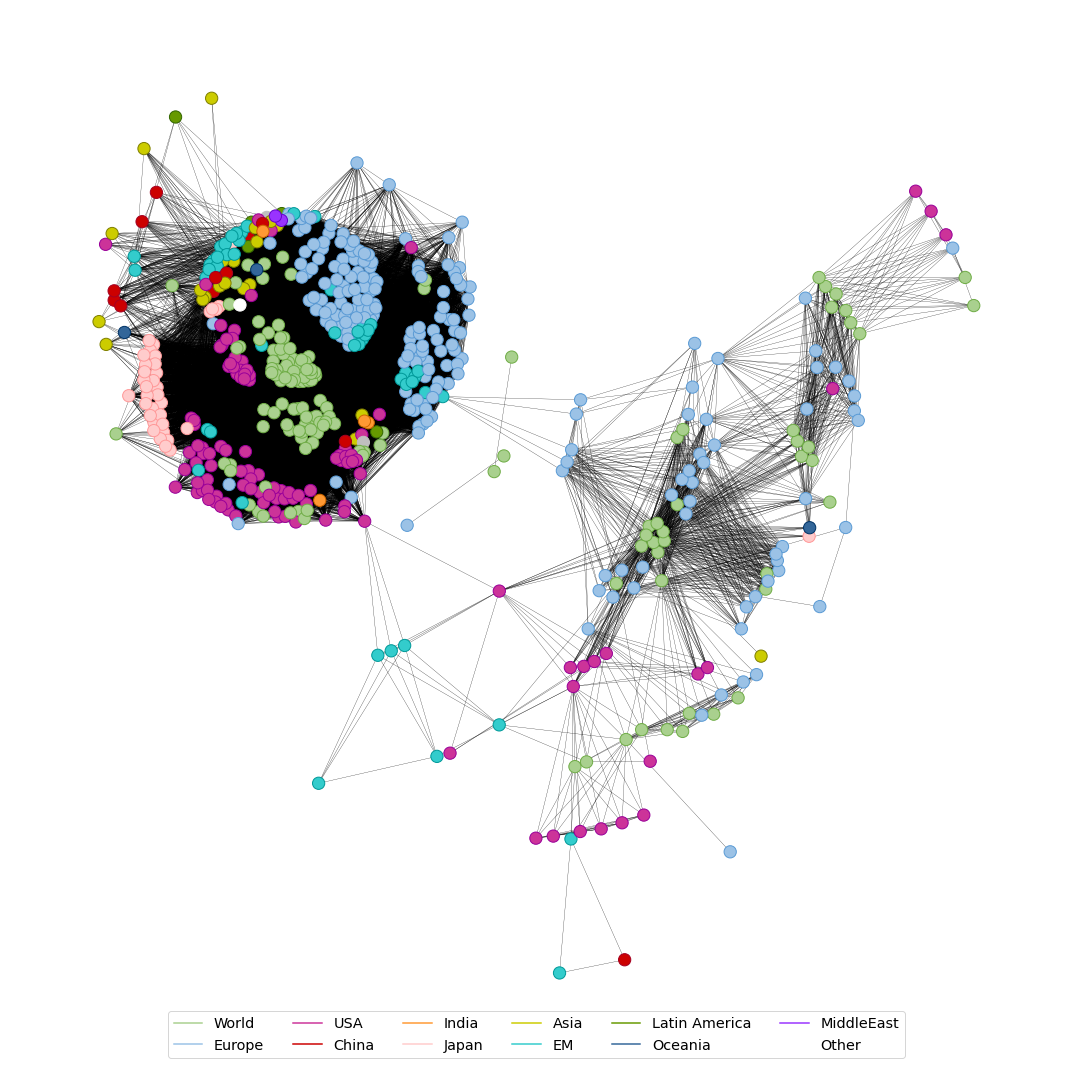

In [35]:
import matplotlib.pyplot as plt
import networkx as nx

# Define minimum weight
df_plot = df[df.Common_Weight >= 0.01].copy()

# Remove two swaps that ruin the graph
# Namely: iShares Diversified Commodity Swap AND MSCI GCC Select Swap
df_plot = df_plot[~df_plot.ISIN_FUND_I.isin(['DE000A0H0728', 'IE00BQXKVQ19'])]
df_plot = df_plot[~df_plot.ISIN_FUND_J.isin(['DE000A0H0728', 'IE00BQXKVQ19'])]

# Remove self-connections
df_plot = df_plot[df_plot.ISIN_FUND_I != df_plot.ISIN_FUND_J]

G = nx.from_pandas_edgelist(df_plot, "ISIN_FUND_I", 'ISIN_FUND_J', ['Common_Weight'])
# position is stored as node attribute data for random_geometric_graph
pos = nx.kamada_kawai_layout(G) 

# Plot all ETFs
df_colors, cond = map_colors(pos, config)
dict_labels = define_labels(config, label_sel = [])

f = plot_network(G, pos, df_colors, cond, dict_labels)

f.savefig('graphics/C010_Network_Common_Weight.png')

In [32]:
# # Remove (almost) no connections
# df_plot = df[df.D_Positions < 0.5].copy()

# # Remove two swaps that ruin the graph
# # Namely: iShares Diversified Commodity Swap AND MSCI GCC Select Swap
# df_plot = df_plot[~df_plot.ISIN_FUND_I.isin(['DE000A0H0728', 'IE00BQXKVQ19'])]
# df_plot = df_plot[~df_plot.ISIN_FUND_J.isin(['DE000A0H0728', 'IE00BQXKVQ19'])]

# # Fill NA
# df_plot.fillna(0, inplace = True)

# # Remove self-connections
# df_plot = df_plot[df_plot.ISIN_FUND_I != df_plot.ISIN_FUND_J]

# G = nx.from_pandas_edgelist(df_plot, "ISIN_FUND_I", 'ISIN_FUND_J', ['D_Positions'])
# # position is stored as node attribute data for random_geometric_graph
# pos = nx.kamada_kawai_layout(G)

# # Plot all ETFs with weights?!
# df_colors, cond = map_colors(pos, config)
# dict_labels = define_labels(config, label_sel = [])

# plot_network(G, pos, df_colors, cond, dict_labels, labels = False)

# Clusters

In [87]:
# Create clusters

from sklearn.cluster import KMeans
import seaborn as sns

import matplotlib.pyplot as plt

# Reshape
df_clust = df.pivot(index = 'ISIN_FUND_I', columns = 'ISIN_FUND_J', values = 'Common_Weight')

df_clust = df_clust.reset_index()

# Fill NA values that were created when reshaping from long to wide
df_clust = df_clust.fillna(0)

# Extract numeric-only subset for clustering
X = df_clust.iloc[:,1:]

Text(0.5, 1.0, 'Elbow curve')

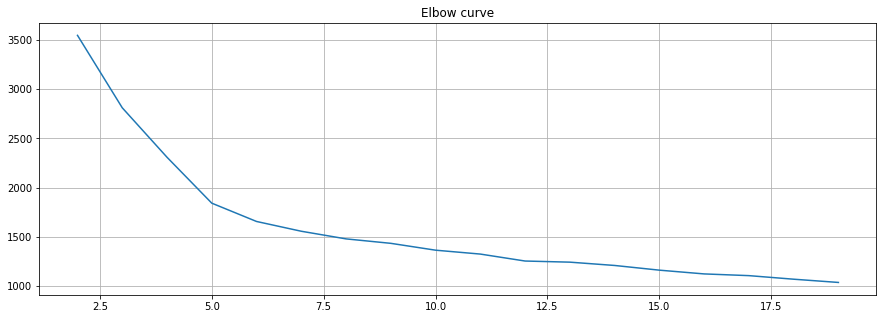

In [61]:
# Minimum 5 Clusters is optimal

# distorsions = []
# for k in range(2, 20):
#     kmeans = KMeans(n_clusters=k)
#     kmeans.fit(X)
#     distorsions.append(kmeans.inertia_)

# fig = plt.figure(figsize=(15, 5))
# plt.plot(range(2, 20), distorsions)
# plt.grid(True)
# plt.title('Elbow curve')

In [135]:
# Determine clusters with KMeans
kmeans = KMeans(n_clusters=6, random_state=0).fit(X)


In [136]:
# Visualize the clusters 
df_plot = df_clust.copy()
df_plot["Clusters"] = kmeans.labels_

df_plot = df_plot.join(
    config[['Security_ISIN', 'Security_Name', 'Topic_Region']].rename(columns = {'Security_ISIN': 'ISIN_FUND_I'}).set_index('ISIN_FUND_I'), on = 'ISIN_FUND_I'
)

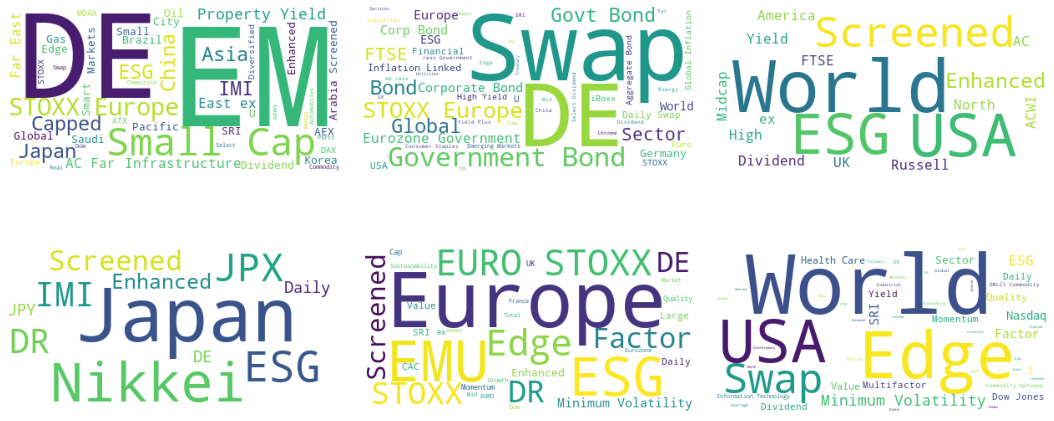

In [213]:
# Create word cloud for each cluster
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Add specific word filters
add_words = [
    'iShares', 'Lyxor', 'MSCI', 'UCITS', 'ETF', 'Dist', 'Acc', 'Core',
    'USD', 'EUR', 'GBP', 'CHF', 'Hedged',
    'ß', 'S', 'P',
    '1C', '1D', '2D', '2C', '3C', '3D', '4C', '4D', '7C'
]

for w in add_words:
    STOPWORDS.add(w)

STOPWORDS = {i.lower() for i in STOPWORDS}

fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (15, 8))

y_l = [0, 1, 2, 0, 1, 2]

for c in range(6):

    x_ = c // 3
    y_ = y_l[c]

    ax = axes[x_,y_]

    cloud = WordCloud(background_color='white', max_words=50, stopwords=set(STOPWORDS))
    cloud.generate(" ".join(df_plot[df_plot.Clusters == c].Security_Name))

    ax.imshow(cloud) 
    ax.axis("off") 

fig.tight_layout(pad = 2) 

fig.savefig('graphics/C010_Simi_Cluster.png')

plt.show() 

